## libs 

In [22]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
import matplotlib.pylab as plab

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from pathlib import Path
from tqdm import tqdm

## initialization

In [23]:
MODEL_DIRECTORY = Path('../../model/')

In [24]:
def get_stars_with_mass(table, name):
    
    main_component = pd.DataFrame(columns=table.columns, index=[0])
    
    for M_1 in table.columns:
        stars = pd.DataFrame(data={'q' : table.index})
        stars['M_2'] = float(M_1) * stars['q']
        
        stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
        stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
        stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])

        G_1 = interp(isochrone['Mini'], isochrone['Gmag'], M_1)
        BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], M_1) 
        RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], M_1)

        stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
        stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                              (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))


        if name == 'g':
            table[M_1] = stars['G, mag'].tolist()
            main_component[M_1] = G_1

        elif name == 'color':
            table[M_1] = stars['BP-RP, mag'].tolist()
            main_component[M_1]= BP_1 - RP_1
        else:
            raise ValueError('wrong name') 

    table = main_component.append(table, ignore_index=False)
    return table


def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def gauss(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

In [25]:
isochrone = pd.read_csv(MODEL_DIRECTORY / (f'isochrone_model_8.5.txt'), delimiter='\\s+')

## qM coordinates grid

In [26]:
#q_array = np.linspace(0.1, 1, 70)
q_array = np.sort(abs(np.geomspace(0.1, 1, 50) - 1.1))
M_array = np.geomspace(0.9, 3, 200)

g_table = pd.DataFrame(columns = M_array, index=q_array)
color_table = pd.DataFrame(columns = M_array, index=q_array)

In [27]:
g_table = get_stars_with_mass(g_table, 'g')
color_table = get_stars_with_mass(color_table, 'color')

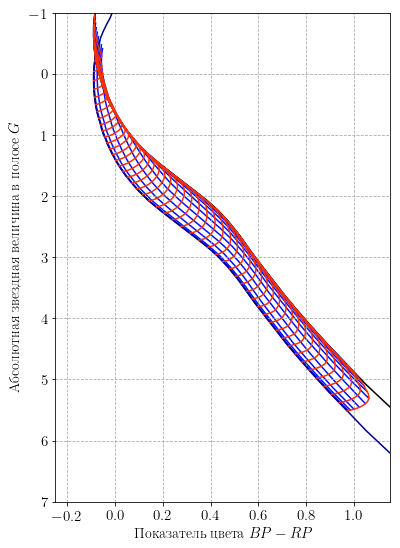

In [28]:
fig, ax = plt.subplots(figsize=(6,9))

plt.rcParams.update({'font.size': 25})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')


colors = plab.cm.jet(np.linspace(0,1,8))

ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'], label='isochrone', color=colors[0])
ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'] - 2.5*np.log10(2), 
        label='isochrone for binaries-twins', color='black')
for i in range(0, 50, 4):
    ax.plot(color_table.iloc[i, :], g_table.iloc[i, :], color=colors[1], label=None, lw=1.5, zorder=1) 
for i in range(0, 199, 4):
    ax.plot(color_table.iloc[:, i], g_table.iloc[:, i], color=colors[6], label=None, lw=1.5, zorder=2)

ax.grid(c='#aaaaaa', ls='--')

plt.xlabel(r'Показатель цвета $BP-RP$')
plt.ylabel(r'Абсолютная звездная величина в полосе $G$', labelpad=8)

#plt.yticks(np.arange(0.8,1.7, step=0.2))
ax.set_xlim(-0.25,1.15)
ax.set_ylim(-1,7)

ax.invert_yaxis()

ax.tick_params(axis='both', which='major')
#ax.legend(loc='upper right')
plt.savefig(MODEL_DIRECTORY / 'plots' / 'qM_coordinate_grids.pdf', bbox_inches = 'tight')

## new coordinates definition for model stars 

In [29]:
model_stars = read_file(MODEL_DIRECTORY / 'model_stars_400pc_manystars_flat.txt')
model_stars = model_stars[(model_stars['BP-RP, mag'] < 1.0) & (model_stars['BP-RP, mag'] > -0.3)]

M_1 = np.ndarray((len(model_stars+1)))
q = np.ndarray((len(model_stars+1)))

In [30]:
model_stars.reset_index(inplace=True)

In [31]:
for i in tqdm(range(len(model_stars))):
    g = model_stars.loc[i,'G, mag']
    color = model_stars.loc[i,'BP-RP, mag']

    g_difference = (g_table - g) * (g_table - g)
    color_difference = (color_table - color) * (color_table - color)
    
    distance = g_difference + color_difference
    M_1[i] = distance.min().idxmin()
    q[i] = distance[M_1[i]].idxmin()

100%|██████████| 4785/4785 [00:22<00:00, 216.42it/s]


In [32]:
model_stars['M_1_detected'] = M_1
model_stars['q_detected'] = q

In [33]:
model_stars['q'] = model_stars['Mass2'] / model_stars['Mass1']
model_stars['q'] = model_stars['q'].fillna(0)

# results analysis 

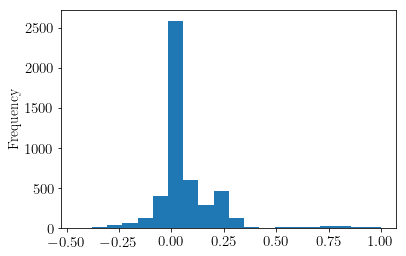

In [34]:
model_stars['q_difference'] = model_stars['q_detected'] - model_stars['q']
model_stars['q_difference'].plot.hist(bins=20)

In [35]:
# mask_ci = (model_stars['BP-RP, mag'] < 0.327) & (model_stars['BP-RP, mag'] > 0.125)
# model_stars = model_stars[mask_ci]

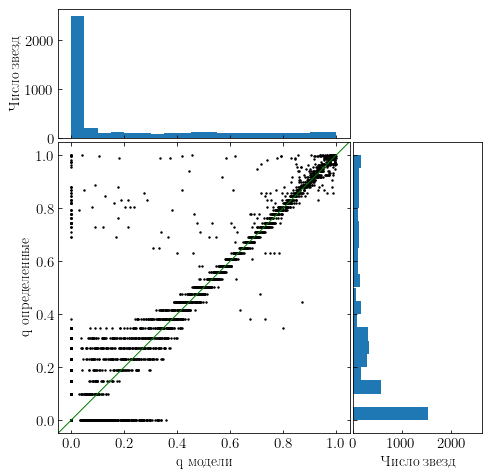

In [62]:
# the random data
x = model_stars['q']
y = model_stars['q_detected']

# definitions for the axes
left, width = 0.1, 0.45
bottom, height = 0.1, 0.45
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(9, 9))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y, s=2, c='black')
ax_scatter.set_xlabel('q модели', fontsize=15)
ax_scatter.set_ylabel('q определенные', fontsize=15)

ax_scatter.plot([-0.5, 1.5], [-0.5, 1.5], c='green', lw=1)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth + 0.05
ax_scatter.set_xlim((-0.05, lim))
ax_scatter.set_ylim((-0.05, lim))

# the hist plot:
bins = 20
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_ylim(top=len(model_stars) * 0.55)
ax_histy.xaxis.set_ticks(ax_histx.get_yticks())
ax_histy.set_xlim(right=len(model_stars) * 0.55)

ax_histx.set_ylabel('Число звезд')
ax_histy.set_xlabel('Число звезд')

plt.savefig(MODEL_DIRECTORY / 'plots' / 'q_distributions.pdf',  bbox_inches = 'tight')

In [37]:
# _mask = (model_stars['q_detected'] < 0.11)
# model_stars.loc[_mask, 'q_detected'] = 0
# model_stars['q_difference'] = model_stars['q_detected'] - model_stars['q']

In [38]:
mask_s = (model_stars['q'] == 0)
mask_b = (model_stars['q'] != 0)

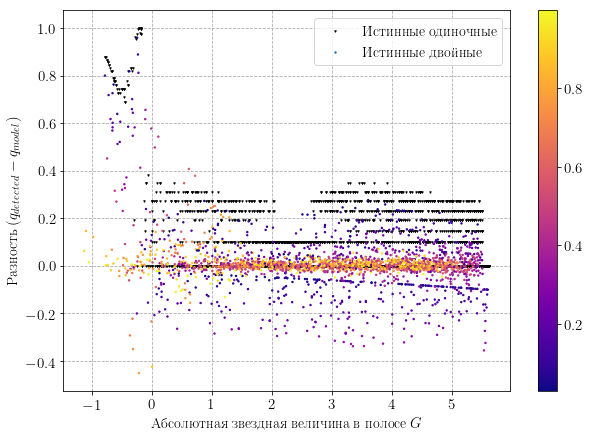

In [39]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(model_stars[mask_s]['G, mag'], model_stars[mask_s]['q_difference'],
           c='black', s=2, marker='v', zorder=5, label='Истинные одиночные')
binaries = ax.scatter(model_stars[mask_b]['G, mag'], model_stars[mask_b]['q_difference'],
           c=model_stars[mask_b]['q'], cmap='plasma', zorder=10, s=2, label='Истинные двойные')

ax.set_xlabel(r'Абсолютная звездная величина в полосе $G$')
ax.set_ylabel(r'Разность $(q_{detected} - q_{model})$')

ax.grid(c='#aaaaaa', ls='--', zorder=0)
ax.legend()
plt.colorbar(binaries) 
ax.tick_params(axis='both', which='major')
#plt.savefig(MODEL_DIRECTORY / 'plots' / 'difference_q(G).pdf',  bbox_inches = 'tight')

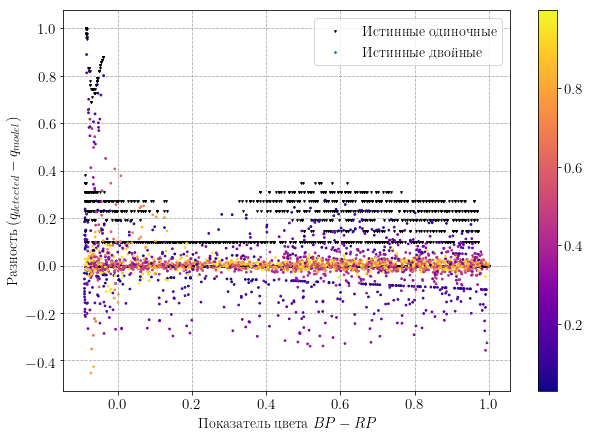

In [40]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(model_stars[mask_s]['BP-RP, mag'], model_stars[mask_s]['q_difference'],
           c='black', s=3, marker='v', zorder=5, label='Истинные одиночные')
binaries = ax.scatter(model_stars[mask_b]['BP-RP, mag'], model_stars[mask_b]['q_difference'],
           c=model_stars[mask_b]['q'], cmap='plasma', zorder=10, s=3, label='Истинные двойные')

ax.set_xlabel(r'Показатель цвета $BP-RP$')
ax.set_ylabel(r'Разность $(q_{detected} - q_{model})$')

ax.grid(c='#aaaaaa', ls='--', zorder=0)
ax.legend()
plt.colorbar(binaries) 
ax.tick_params(axis='both', which='major')
#plt.savefig(MODEL_DIRECTORY / 'plots' / 'difference_q(BP-RP).pdf',  bbox_inches = 'tight')

слева у двойной (№17, q=0.79) показатель преломления 0.126
справа у одиночной (№2661) показатель преломления 0.327

в этот промежуток ошибку определения больше 0.1 имеют двойные с q=0.05

более слабое определение от 0.1 до 0.4


In [159]:
#model_stars[(model_stars['q_difference'] >0.2) & (model_stars['BP-RP, mag'] >0.1) & (model_stars['BP-RP, mag'] <0.4)]['BP-RP, mag']

In [136]:
mask_0 = (model_stars['BP-RP, mag'] < 0.25) 
mask_1 = (model_stars['BP-RP, mag'] > 0.25) & (model_stars['BP-RP, mag'] < 0.5) 
mask_2 = (model_stars['BP-RP, mag'] < 0.75) & (model_stars['BP-RP, mag'] > 0.5) 
mask_3 = (model_stars['BP-RP, mag'] > 0.75)

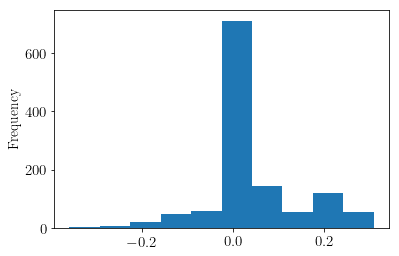

In [120]:
model_stars[mask_3]['q_difference'].plot.hist()